In [29]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees

In [30]:
data = pd.read_csv('chapter1_cleaned_data.csv')

In [31]:
features_response = data.columns.tolist()
remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT', 'graduate school', 'high school', 'none', 'others', 'university']
features_response = [item for item in features_response if item not in remove]

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data[features_response[:-1]].values, data['default payment next month'].values, test_size=0.2, random_state=24)

In [34]:
decision_tree = tree.DecisionTreeClassifier(max_depth=2)

In [35]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [36]:
dot_data = tree.export_graphviz(decision_tree, out_file=None, filled=True,rounded=True, feature_names=features_response[:-1],proportion=True, class_names=['Notdefaulted', 'Defaulted'])

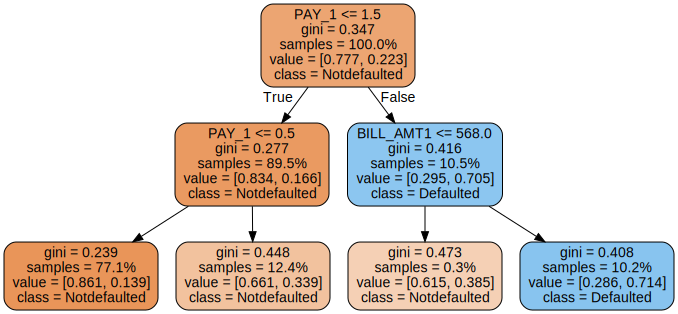

In [37]:
graph = graphviz.Source(dot_data)
graph

Exercise 20: Finding Optimal Hyperparameters for a Decision Tree

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
X_train.shape

(21331, 17)

Since we will be using 4 folds, we will have 3/4 of the data to train our model, around 16000 samples. A theoretical limit to the max depth of the tree is so that we have one sample per leaf, the number of leafs is 2^n (n being the depth), from that we can take that the teorical limit for our tree is around depth 14. However, a tree that has one sample per leaf is extremely overfit, so we will explore up to depth 12. 

In [40]:
params = {'max_depth':[1, 2, 4, 6, 8, 10, 12]}

In [41]:
cv = GridSearchCV(decision_tree, param_grid=params, scoring='roc_auc',n_jobs=None, refit=True, cv=4, verbose=1,pre_dispatch=None, error_score=np.nan, return_train_score=True)

In [42]:
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [43]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.040178,0.014796,0.485103,0.834452,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.054729,0.001288,0.004777,0.001284,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.114901,0.006473,0.003998,0.001223,4,{'max_depth': 4},0.732720,0.741078,0.746946,0.743731,0.741119,0.005276,2,0.756882,0.752421,0.749368,0.753055,0.752932,0.002673
3,0.150516,0.002604,0.005499,0.000865,6,{'max_depth': 6},0.744848,0.745914,0.750630,0.741588,0.745745,0.003240,1,0.782202,0.780125,0.775228,0.774776,0.778083,0.003171
4,0.219368,0.034714,0.005497,0.001498,8,{'max_depth': 8},0.728527,0.732583,0.750618,0.732522,0.736062,0.008563,3,0.811734,0.808296,0.803345,0.802004,0.806345,0.003895
5,0.287125,0.028230,0.004717,0.001270,10,{'max_depth': 10},0.707321,0.703408,0.721979,0.713443,0.711538,0.007010,4,0.848747,0.853789,0.841149,0.836862,0.845137,0.006562
6,0.338567,0.033845,0.005241,0.002166,12,{'max_depth': 12},0.677524,0.656950,0.676284,0.681907,0.673166,0.009593,6,0.887988,0.903592,0.885465,0.875446,0.888123,0.010088


Text(0, 0.5, 'ROC AUC')

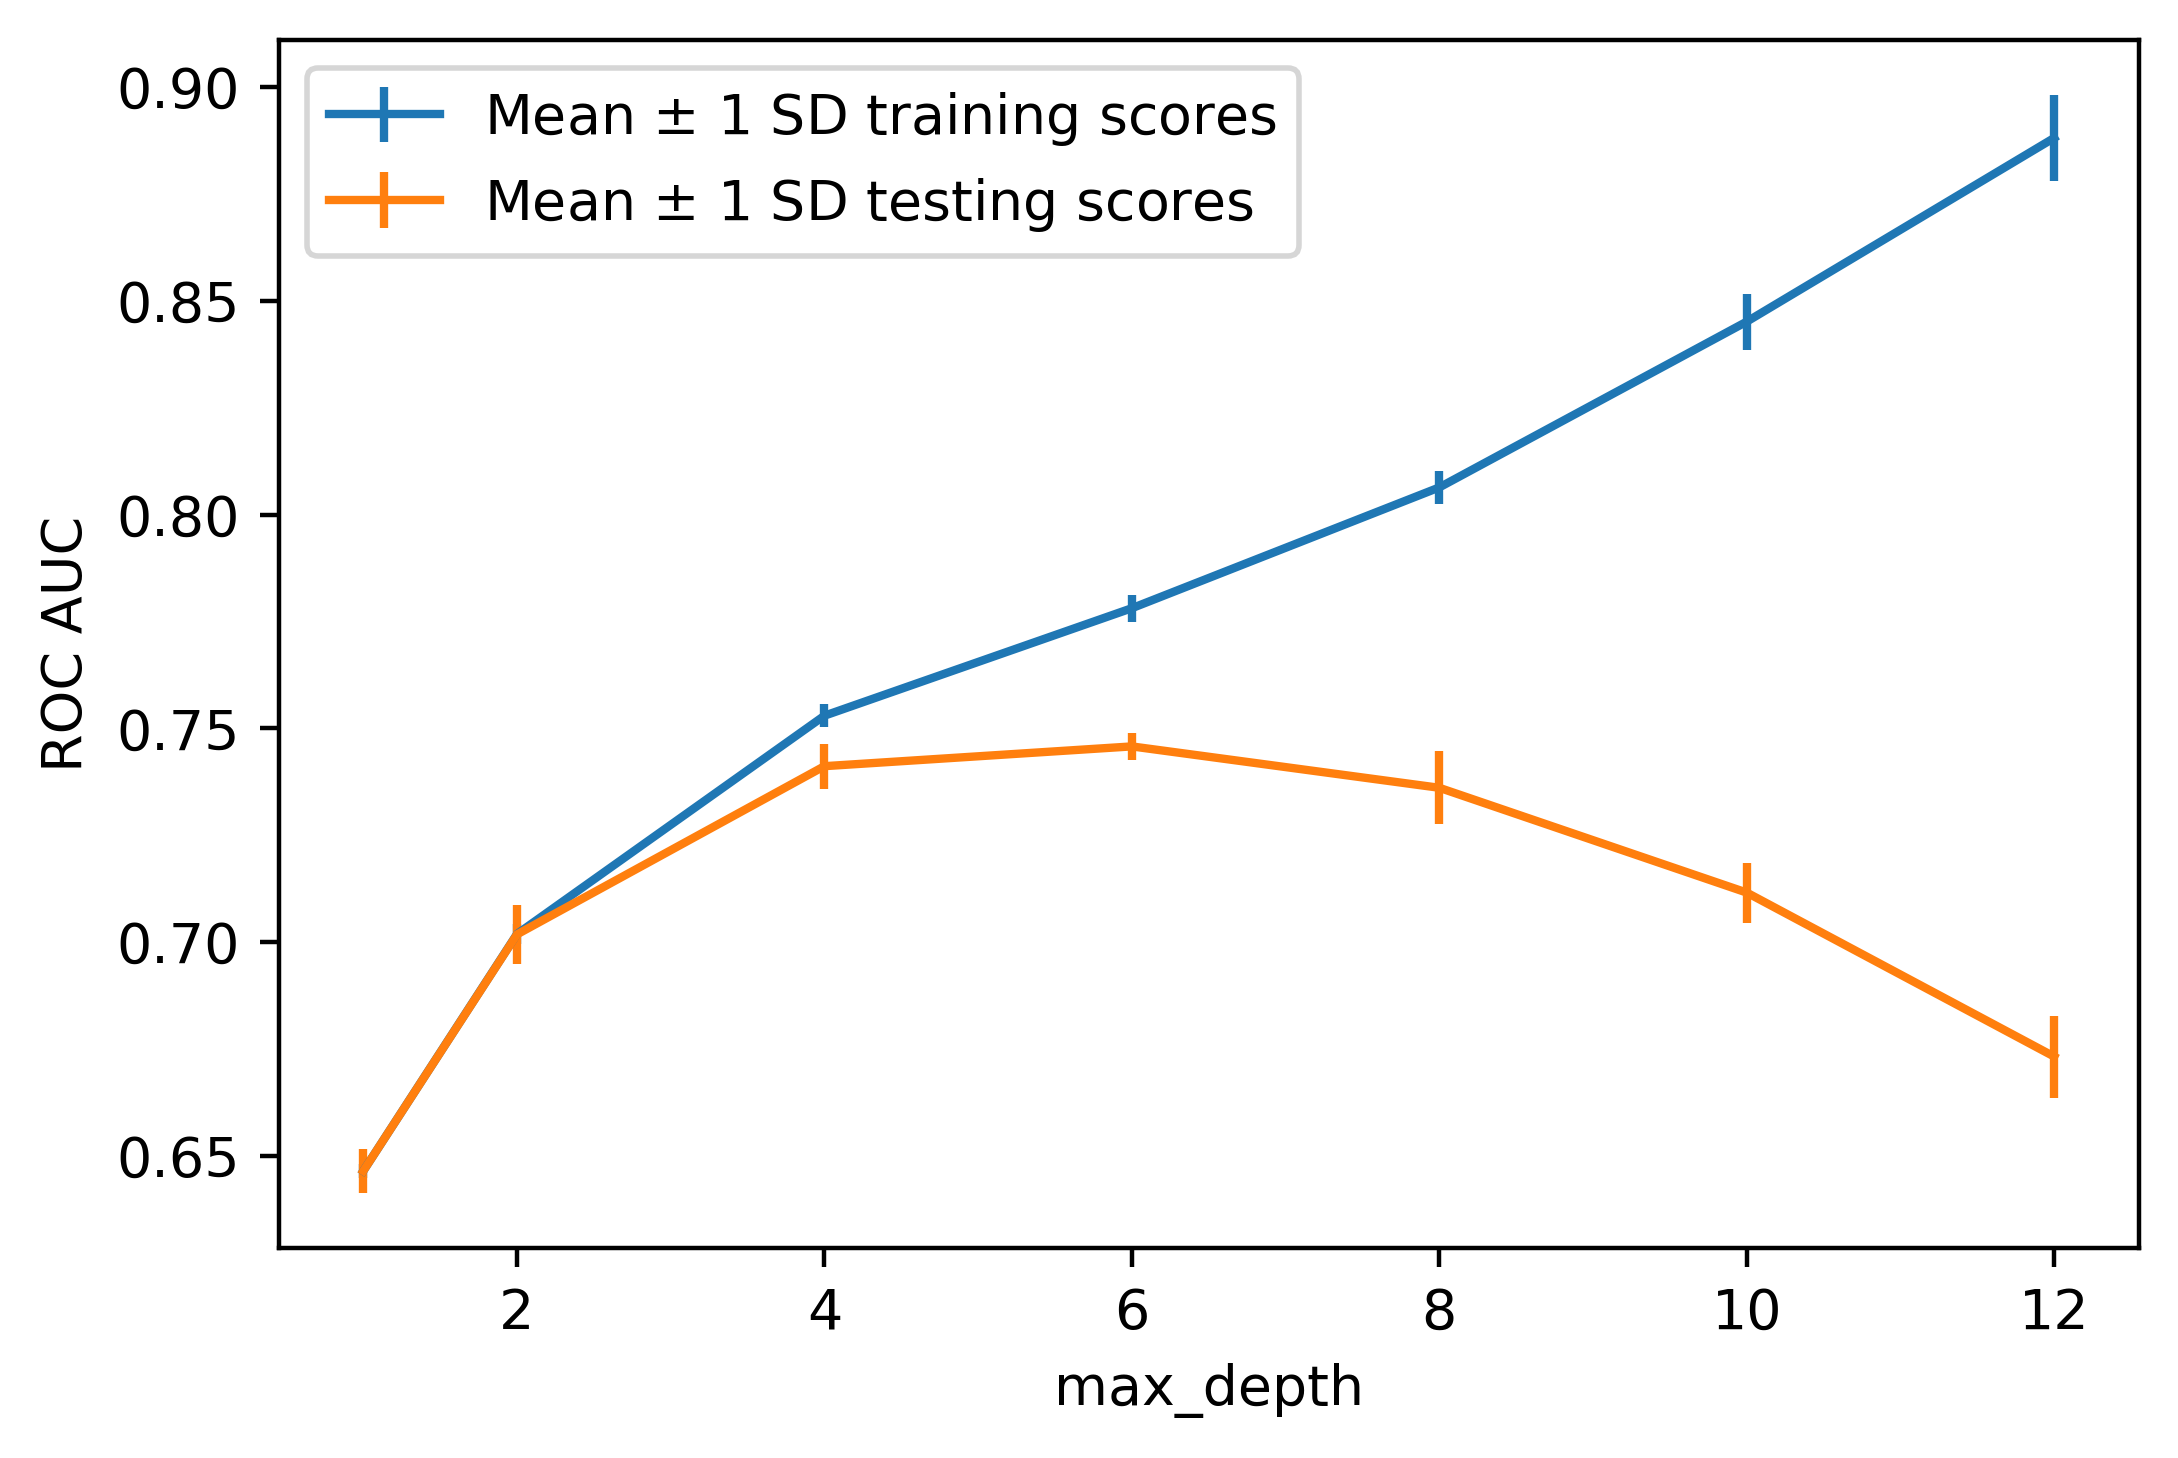

In [44]:
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'], cv_results_df['mean_train_score'], yerr=cv_results_df['std_train_score'], label='Mean $\pm$ 1 SD training scores')
ax.errorbar(cv_results_df['param_max_depth'], cv_results_df['mean_test_score'], yerr=cv_results_df['std_test_score'],label='Mean $\pm$ 1 SD testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

Exercise 21: Fitting a Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
random_forest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=3,min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=4, verbose=0, warm_start=False, class_weight=None)

In [47]:
rf_params_ex = {'n_estimators':list(range(10,110,10))}

In [50]:
cv_rf_ex = GridSearchCV(random_forest, param_grid=rf_params_ex, scoring='roc_auc', n_jobs=None, refit=True, cv=4, verbose=1, pre_dispatch=None, error_score=np.nan, return_train_score=True)

In [51]:
cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [52]:
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)

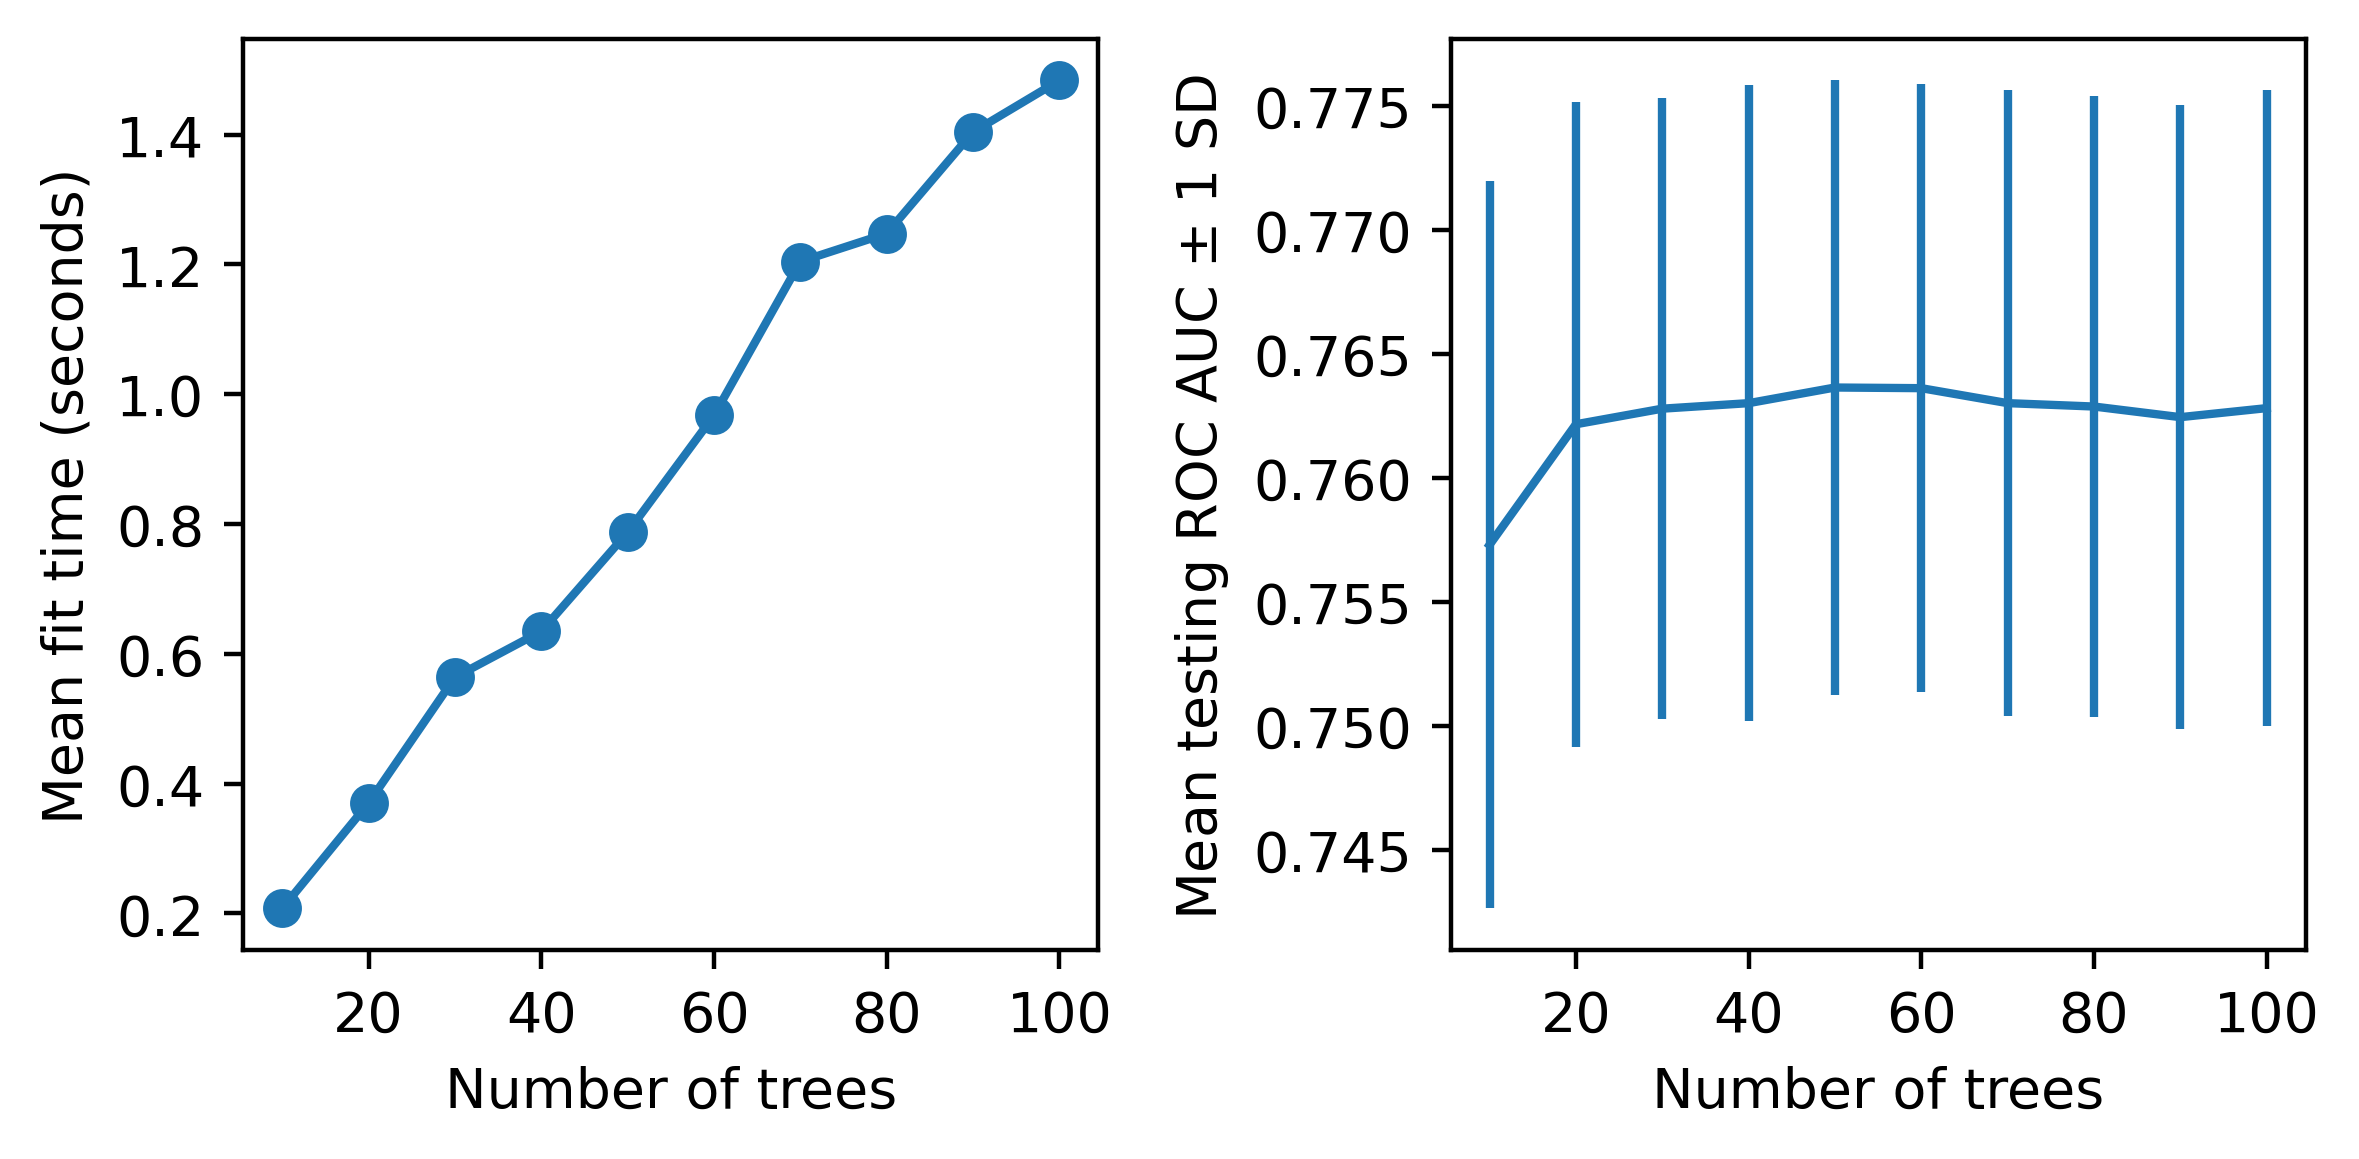

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],cv_rf_ex_results_df['mean_fit_time'],'-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'], cv_rf_ex_results_df['mean_test_score'],yerr=cv_rf_ex_results_df['std_test_score'])
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SD ')
plt.tight_layout()

In [55]:
cv_rf_ex.best_params_

{'n_estimators': 50}

In [57]:
feat_imp_df = pd.DataFrame({'Feature name':features_response[:-1], 'Importance':cv_rf_ex.best_estimator_.feature_importances_})
feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
4,PAY_1,0.609609
11,PAY_AMT1,0.094123
0,LIMIT_BAL,0.079265
13,PAY_AMT3,0.047067
12,PAY_AMT2,0.035393
6,BILL_AMT2,0.022422
14,PAY_AMT4,0.021164
15,PAY_AMT5,0.015962
10,BILL_AMT6,0.014293
8,BILL_AMT4,0.013454


Checkerboard Graph

In [58]:
xx_example, yy_example = np.meshgrid(range(5), range(5))
print(xx_example)
print(yy_example)

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


In [59]:
z_example = np.arange(1,17).reshape(4,4)
z_example

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

Text(0, 0.5, 'Y coordinate')

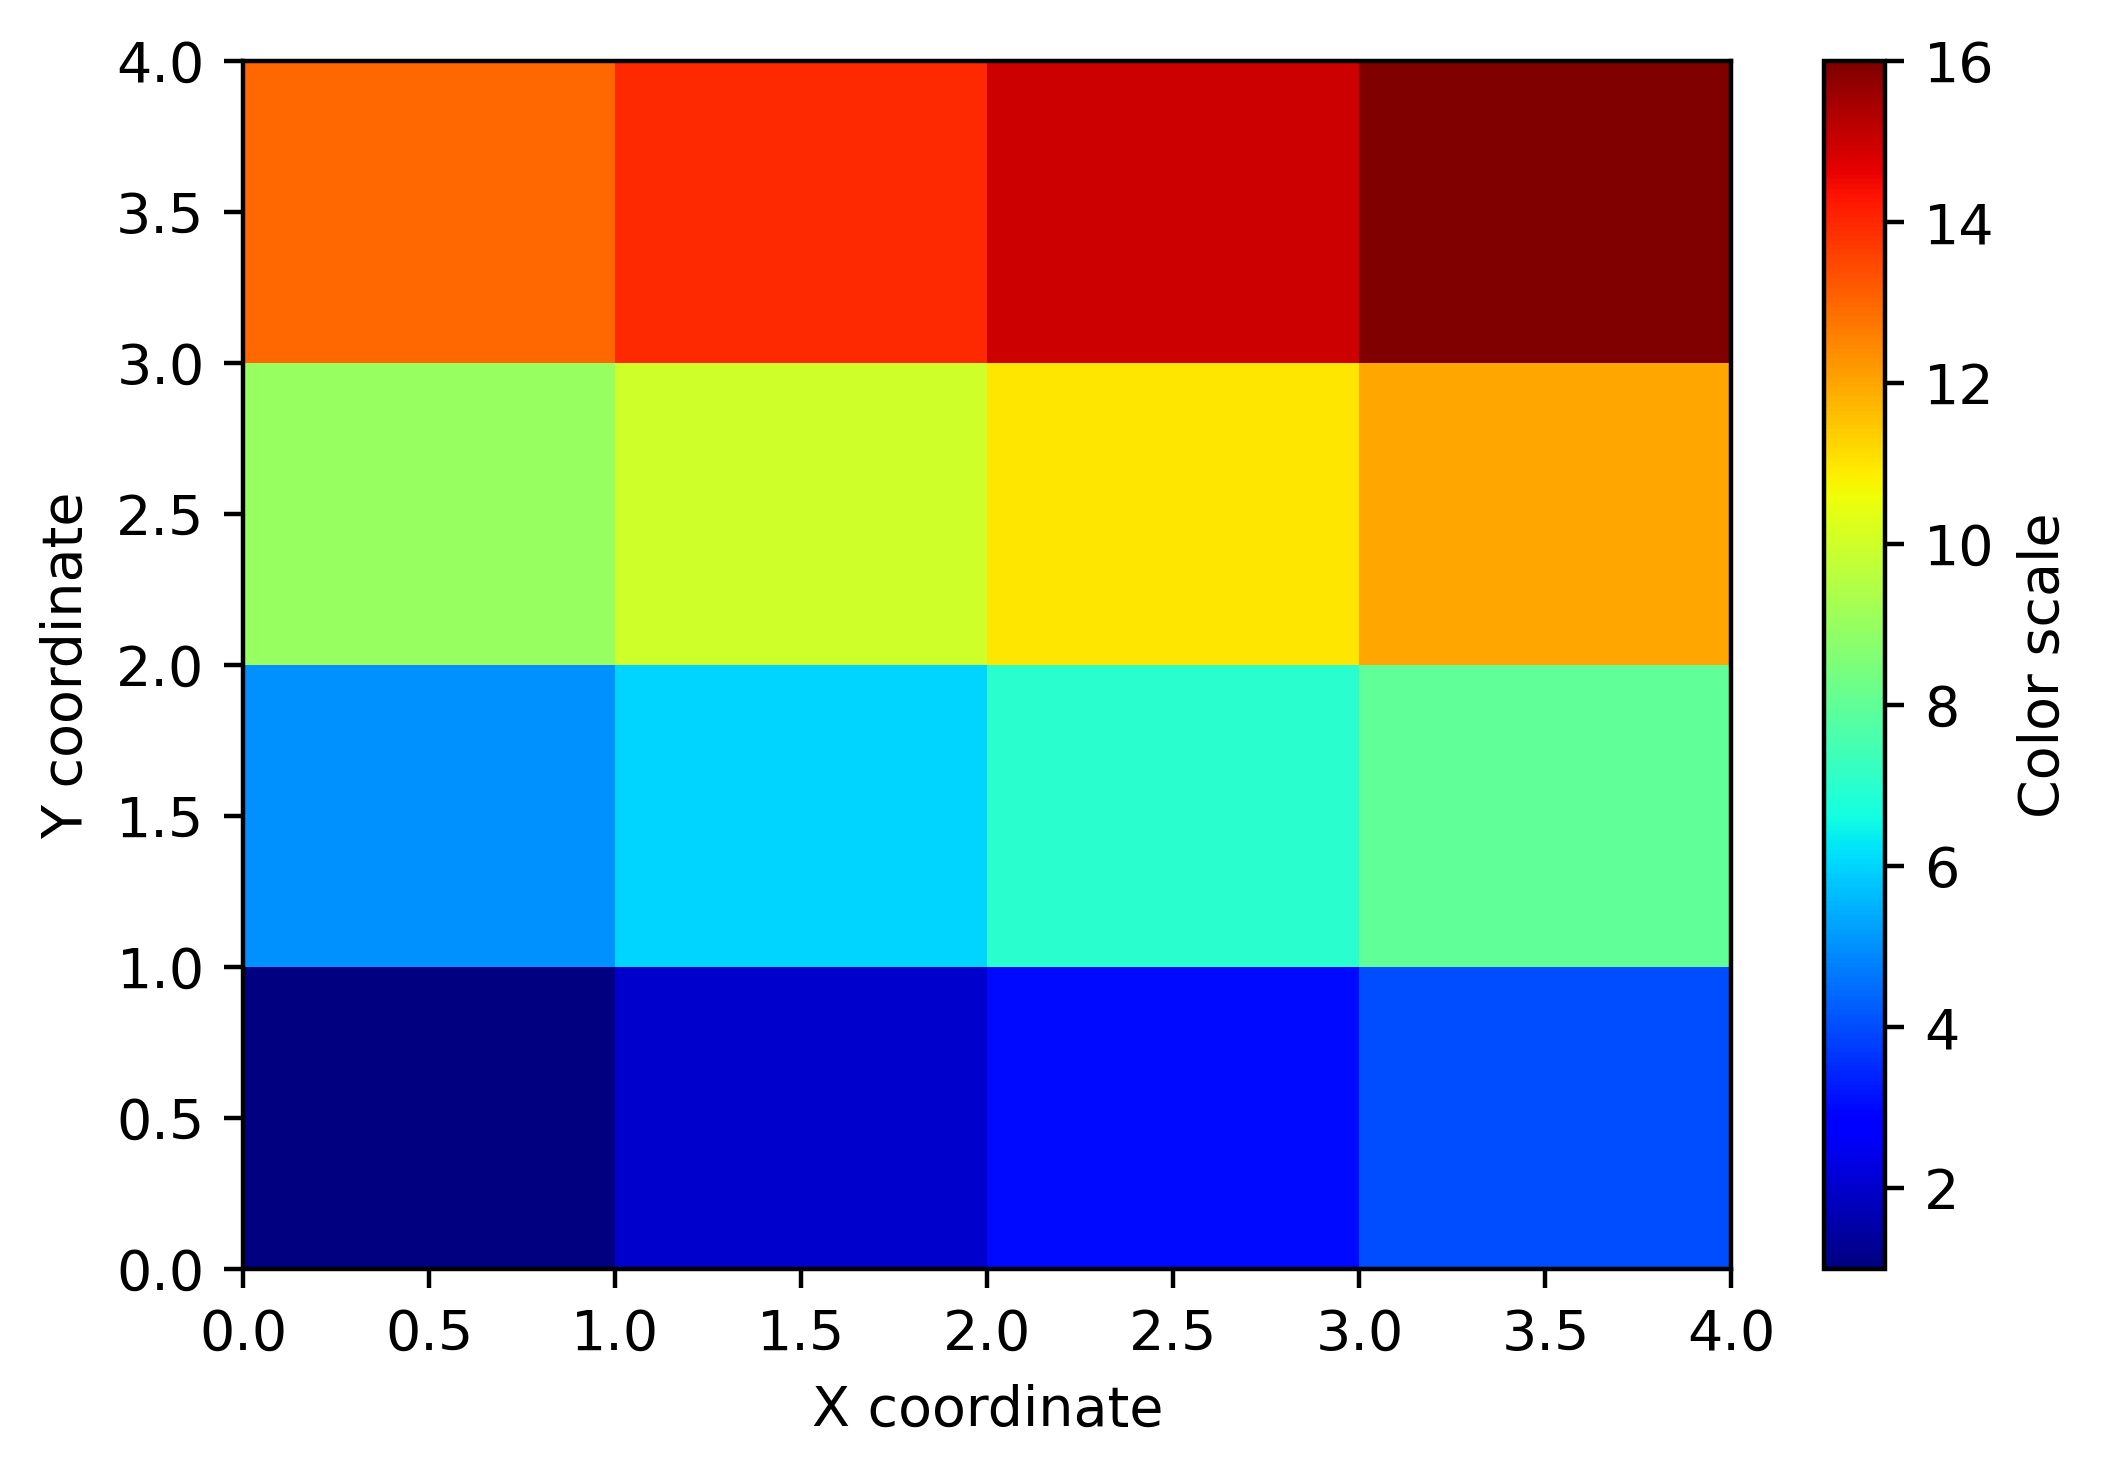

In [61]:
ax = plt.axes()
pcolor_ex = ax.pcolormesh(xx_example, yy_example, z_example, cmap=plt.cm.jet)
plt.colorbar(pcolor_ex, label='Color scale')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

# Activity 5: Cross-Validation Grid Search with Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(criterion='gini',min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=4, verbose=0, warm_start=False, class_weight=None)

In [62]:
hyper_params = {'max_depth': [3, 6, 9, 12], 'n_estimators': [10, 50, 100, 200]}

In [64]:
from sklearn.model_selection import GridSearchCV
cross_validation = GridSearchCV(random_forest, hyper_params, scoring='roc_auc', n_jobs=None, refit=True, cv=4, verbose=2, pre_dispatch=None, error_score=np.nan, return_train_score=True)

In [65]:
cross_validation.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.8s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.8s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.8s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.9s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.8s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.6s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.6s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.6s
[CV] END ......................max_depth=3, n_es

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=2)

In [68]:
cv_results_df = pd.DataFrame(cross_validation.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.490718,0.240079,0.044225,0.037996,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,15,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.871710,0.047678,0.037480,0.002290,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,12,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
2,1.639213,0.010021,0.066967,0.003936,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,13,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750
3,3.885347,0.198405,0.175056,0.034667,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.747454,0.753057,0.777644,0.771729,0.762471,0.012550,14,0.774453,0.773534,0.766139,0.767404,0.770382,0.003653
4,0.369289,0.036177,0.022986,0.009050,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.752905,0.758904,0.780036,0.774017,0.766466,0.010980,11,0.795911,0.796476,0.793695,0.796446,0.795632,0.001141
5,1.620923,0.114990,0.054965,0.007539,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
6,3.182233,0.515158,0.087696,0.004604,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
7,7.436781,0.481093,0.258988,0.090267,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
8,0.486754,0.055236,0.014848,0.001872,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211
9,2.329965,0.102898,0.070338,0.009251,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672


In [91]:
xx, yy = np.meshgrid(range(5), range(5))
z_test_score = cv_results_df['mean_test_score'].values.reshape(4,4)

[Text(0, 0.5, '3'), Text(0, 1.5, '6'), Text(0, 2.5, '9'), Text(0, 3.5, '12')]

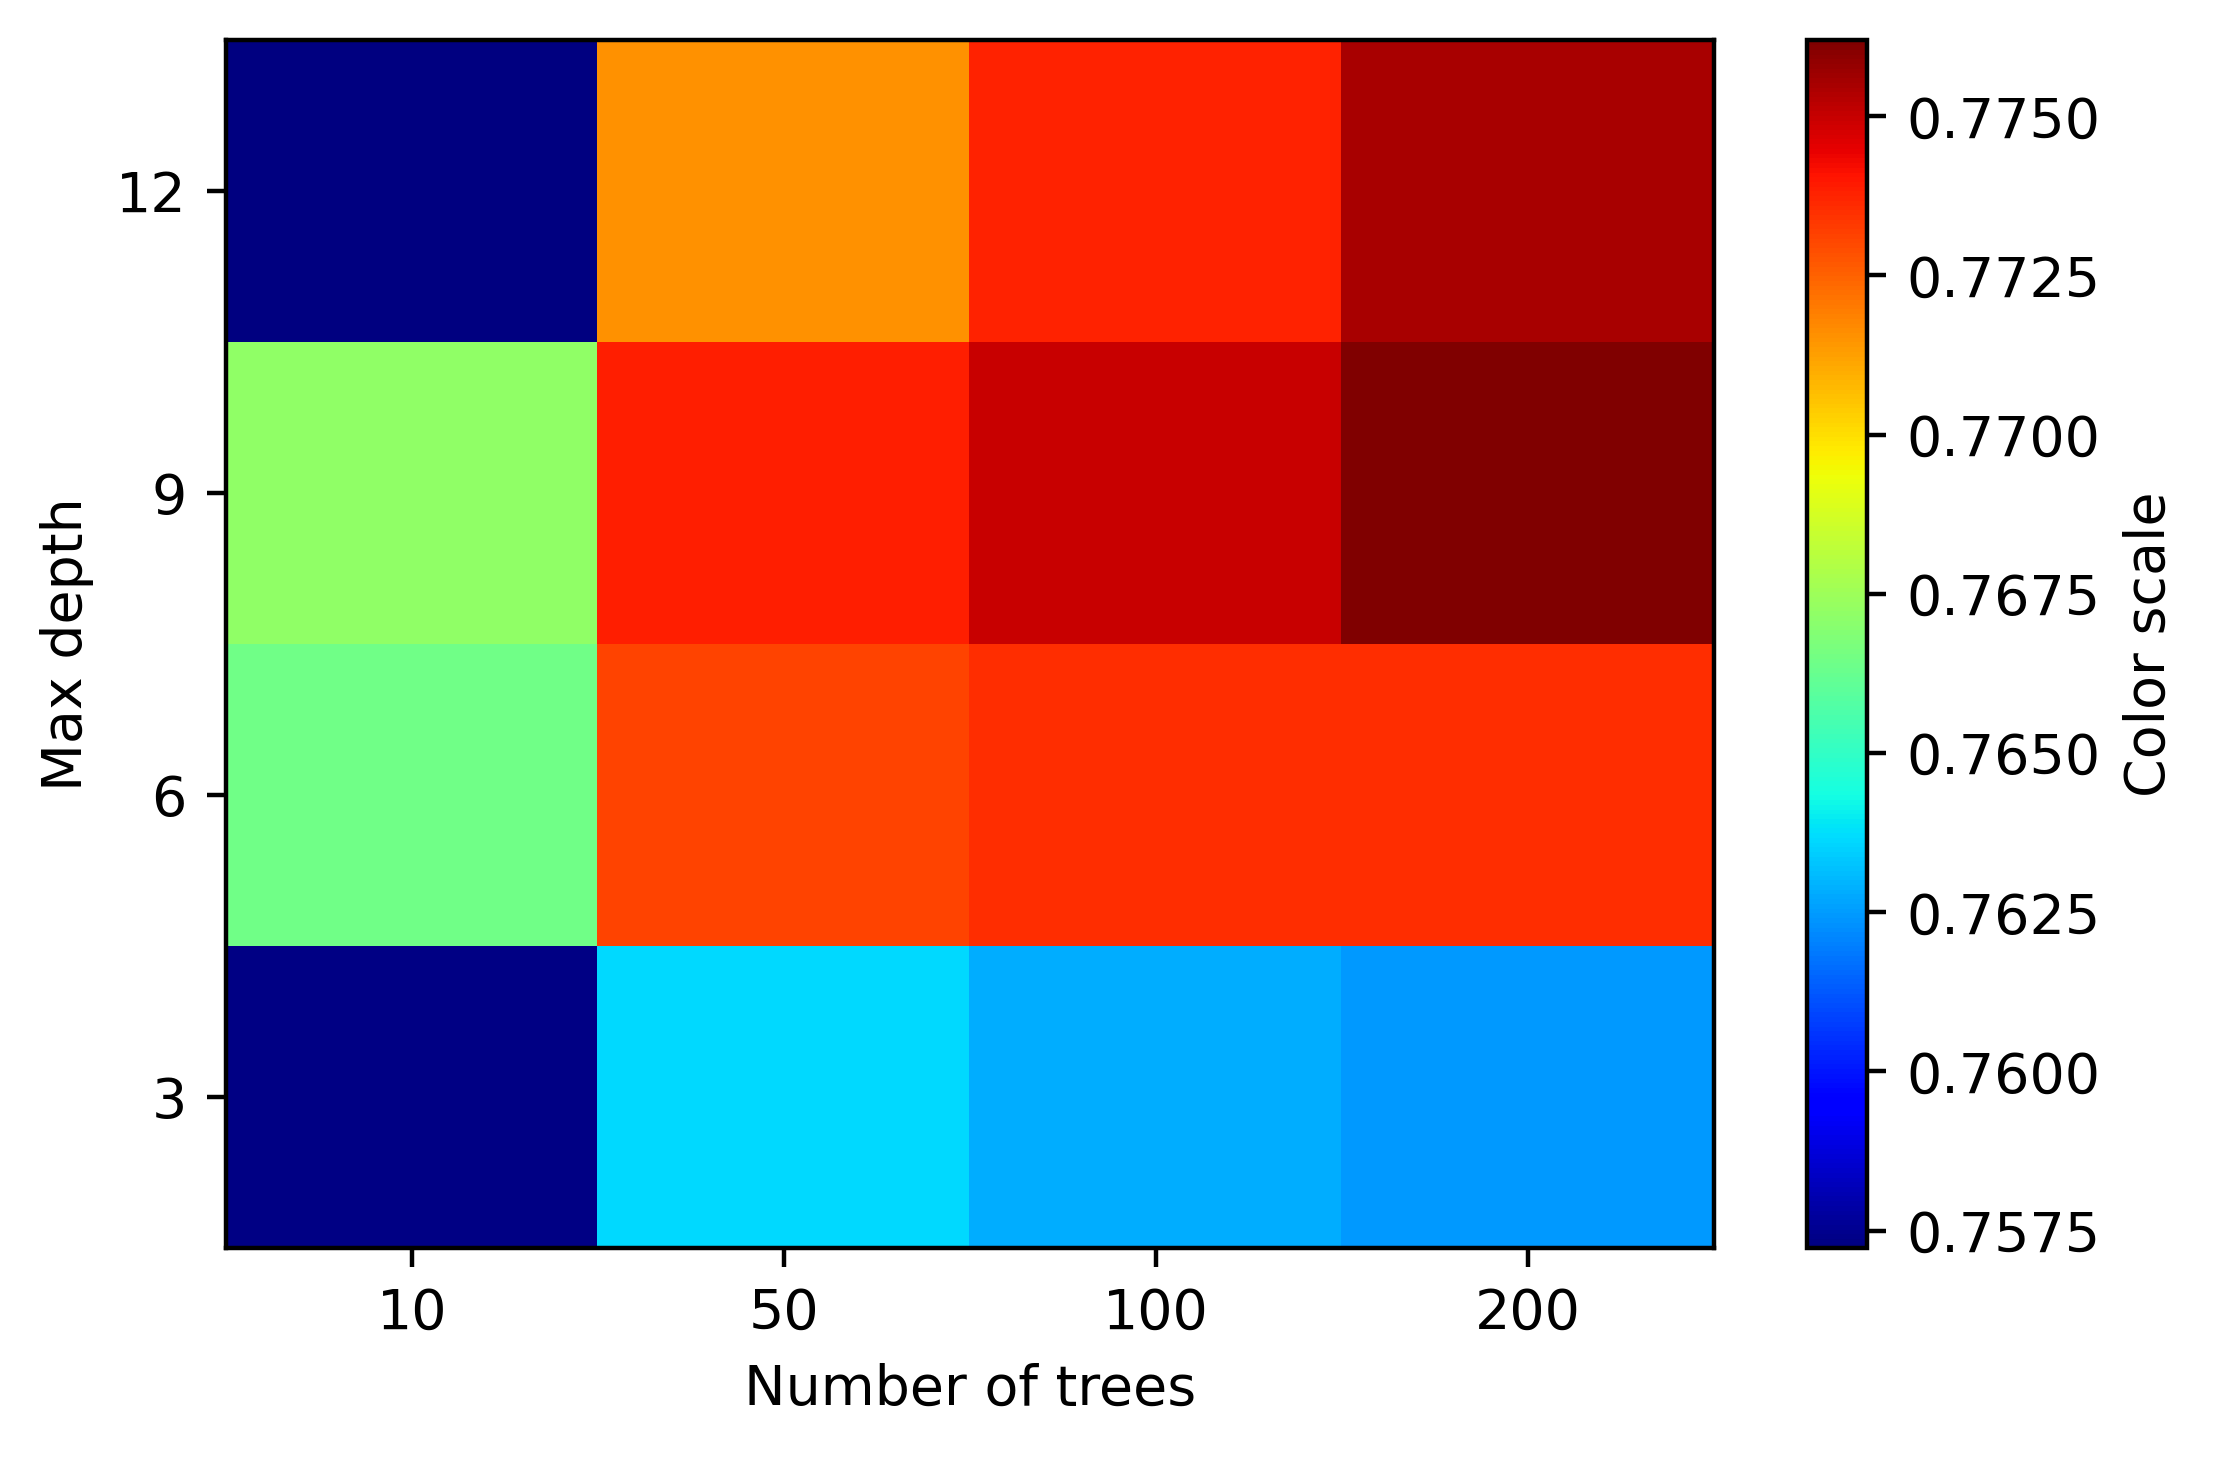

In [92]:
ax = plt.axes()
pcolor_ex = ax.pcolormesh(xx, yy, z_test_score, cmap=plt.cm.jet)
plt.colorbar(pcolor_ex, label='Color scale')
ax.set_xlabel('Number of trees')
ax.set_ylabel('Max depth')
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels([str(tick_label) for tick_label in hyper_params['n_estimators']])
ax.set_yticklabels([str(tick_label) for tick_label in hyper_params['max_depth']])